# Mouse Trajectory Analysis

Analyze and visualize trajectories recorded by the web capture app.

What this notebook does:
- Loads a session `session_*.jsonl` from `../data`.
- Plots all trajectories centered at (0,0).
- Computes metrics per trial: path length, straight-line distance, efficiency, movement time, peak speed, normalized jerk (smoothness).
- Visualizes distributions and the average speed profile over normalized time.

Tip: If imports fail, install deps in your environment:
```bash
pip install numpy pandas matplotlib seaborn
```


In [10]:
import json, os, glob, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')
# Improve inline render crispness (retina) and DPI for clarity
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('retina')
except Exception:
    pass
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['savefig.dpi'] = 160
DATA_DIR = (Path.cwd() / '..' / 'data').resolve()
DATA_DIR


PosixPath('/Users/joshuakirstein/Desktop/projects/mouse_data_gather/data')

In [11]:
# Select a session file: by default, pick the latest session_*.jsonl in ../data
session_files = sorted(DATA_DIR.glob('session_*.jsonl'))
if not session_files:
    raise FileNotFoundError(f'No session_*.jsonl files found in {DATA_DIR}. Run the web capture to generate data.')
session_file = session_files[-1]
session_file


PosixPath('/Users/joshuakirstein/Desktop/projects/mouse_data_gather/data/session_d2c330dd-9711-463c-a331-33750bca642d.jsonl')

In [12]:
# Load trials (one JSON object per line)
trials = []
with open(session_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
            if isinstance(rec.get('path'), list) and len(rec['path']) >= 2:
                trials.append(rec)
        except Exception as e:
            print('Skipping line:', e)
len(trials)


200

In [13]:
# Utilities to convert trial dicts to numpy arrays and compute metrics
from typing import Dict, Any, Tuple

def trial_arrays(trial: Dict[str, Any]):
    path = trial['path']
    t = np.array([p['t'] for p in path], dtype=float)
    x = np.array([p['x'] for p in path], dtype=float)
    y = np.array([p['y'] for p in path], dtype=float)
    # Ensure time starts at 0 and is strictly increasing (drop duplicates)
    t = t - t.min()
    keep = np.r_[True, np.diff(t) > 0]
    t, x, y = t[keep], x[keep], y[keep]
    return t, x, y

def path_length(x: np.ndarray, y: np.ndarray) -> float:
    dx = np.diff(x)
    dy = np.diff(y)
    return float(np.sum(np.hypot(dx, dy)))

def straight_line_distance(trial: Dict[str, Any], x0: float, y0: float) -> float:
    tar = trial.get('target', {})
    tx, ty = float(tar.get('x', x0)), float(tar.get('y', y0))
    return float(np.hypot(tx - x0, ty - y0))

def derivatives(t: np.ndarray, s: np.ndarray) -> np.ndarray:
    # Robust numerical derivative with non-uniform sampling
    return np.gradient(s, t)

def kinematics(t: np.ndarray, x: np.ndarray, y: np.ndarray):
    vx = derivatives(t, x)
    vy = derivatives(t, y)
    speed = np.hypot(vx, vy)
    ax = derivatives(t, vx)
    ay = derivatives(t, vy)
    jerkx = derivatives(t, ax)
    jerky = derivatives(t, ay)
    jerk = np.hypot(jerkx, jerky)
    return vx, vy, speed, ax, ay, jerk

def normalized_jerk(t: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    # Dimensionless jerk metric: (T^5 / L^2) * ∫||jerk||^2 dt
    if len(t) < 5:
        return np.nan
    T = float(t[-1] - t[0])
    if T <= 0:
        return np.nan
    L = path_length(x, y)
    if L <= 1e-6:
        return np.nan
    _, _, _, _, _, jerk = kinematics(t, x, y)
    integral = float(np.trapz(jerk**2, t))
    return (T**5 / (L**2)) * integral

def resample_profile(t: np.ndarray, y: np.ndarray, n: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    # Normalize time to [0,1] and interpolate y onto a uniform grid
    if len(t) < 2:
        u = np.linspace(0, 1, n)
        return u, np.full_like(u, np.nan)
    t0, T = float(t[0]), float(t[-1] - t[0])
    if T <= 0:
        u = np.linspace(0, 1, n)
        return u, np.full_like(u, np.nan)
    u_raw = (t - t0) / T
    u = np.linspace(0, 1, n)
    y_interp = np.interp(u, u_raw, y)
    return u, y_interp


In [14]:
# Build a per-trial metrics table and per-trial speed profiles
metrics = []
profiles = []  # list of (u, speed_u) per trial
clean_trials = []
for tr in trials:
    try:
        t, x, y = trial_arrays(tr)
        if len(t) < 3:
            continue
        # Center at start (0,0) for plotting
        x0, y0 = x[0], y[0]
        xc, yc = x - x0, y - y0
        L = path_length(x, y)
        D = straight_line_distance(tr, x[0], y[0])
        eff = D / L if L > 1e-6 else np.nan
        T = float(t[-1] - t[0])
        vx, vy, speed, ax, ay, jerk = kinematics(t, x, y)
        njerk = normalized_jerk(t, x, y)
        peak_speed = float(np.nanmax(speed)) if len(speed) else np.nan
        profiles.append(resample_profile(t, speed, n=150)[1])
        metrics.append({
            'trial': tr.get('trial', None),
            'T_movement': T,
            'path_length': L,
            'straight_distance': D,
            'efficiency': eff,
            'peak_speed': peak_speed,
            'norm_jerk': njerk,
        })
        clean_trials.append((t, xc, yc, speed, jerk, tr))
    except Exception as e:
        print('Skip trial due to error:', e)

metrics_df = pd.DataFrame(metrics)
metrics_df.describe(include='all')


/var/folders/g4/37bcpps57bl8gsrxqvwdj_c40000gn/T/ipykernel_70848/560859396.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = float(np.trapz(jerk**2, t))


,trial,T_movement,path_length,straight_distance,efficiency,peak_speed,norm_jerk
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,100.500000,0.777084,354.567822,323.870876,0.909215,2518.719862,8.582575e+05
std,57.879185,0.183861,154.898094,149.055168,0.112881,1278.071949,1.973544e+06
min,1.000000,0.387000,84.013564,74.569277,0.349491,564.135669,1.204186e+04
25%,50.750000,0.668975,229.710547,203.810161,0.876086,1574.055566,1.285118e+05
50%,100.500000,0.768250,346.044233,313.690070,0.947626,2262.030954,3.666470e+05
75%,150.250000,0.852725,451.022200,428.319799,0.979103,3325.199017,8.018979e+05
max,200.000000,1.617100,797.507545,701.016523,1.053274,7007.821004,2.230290e+07


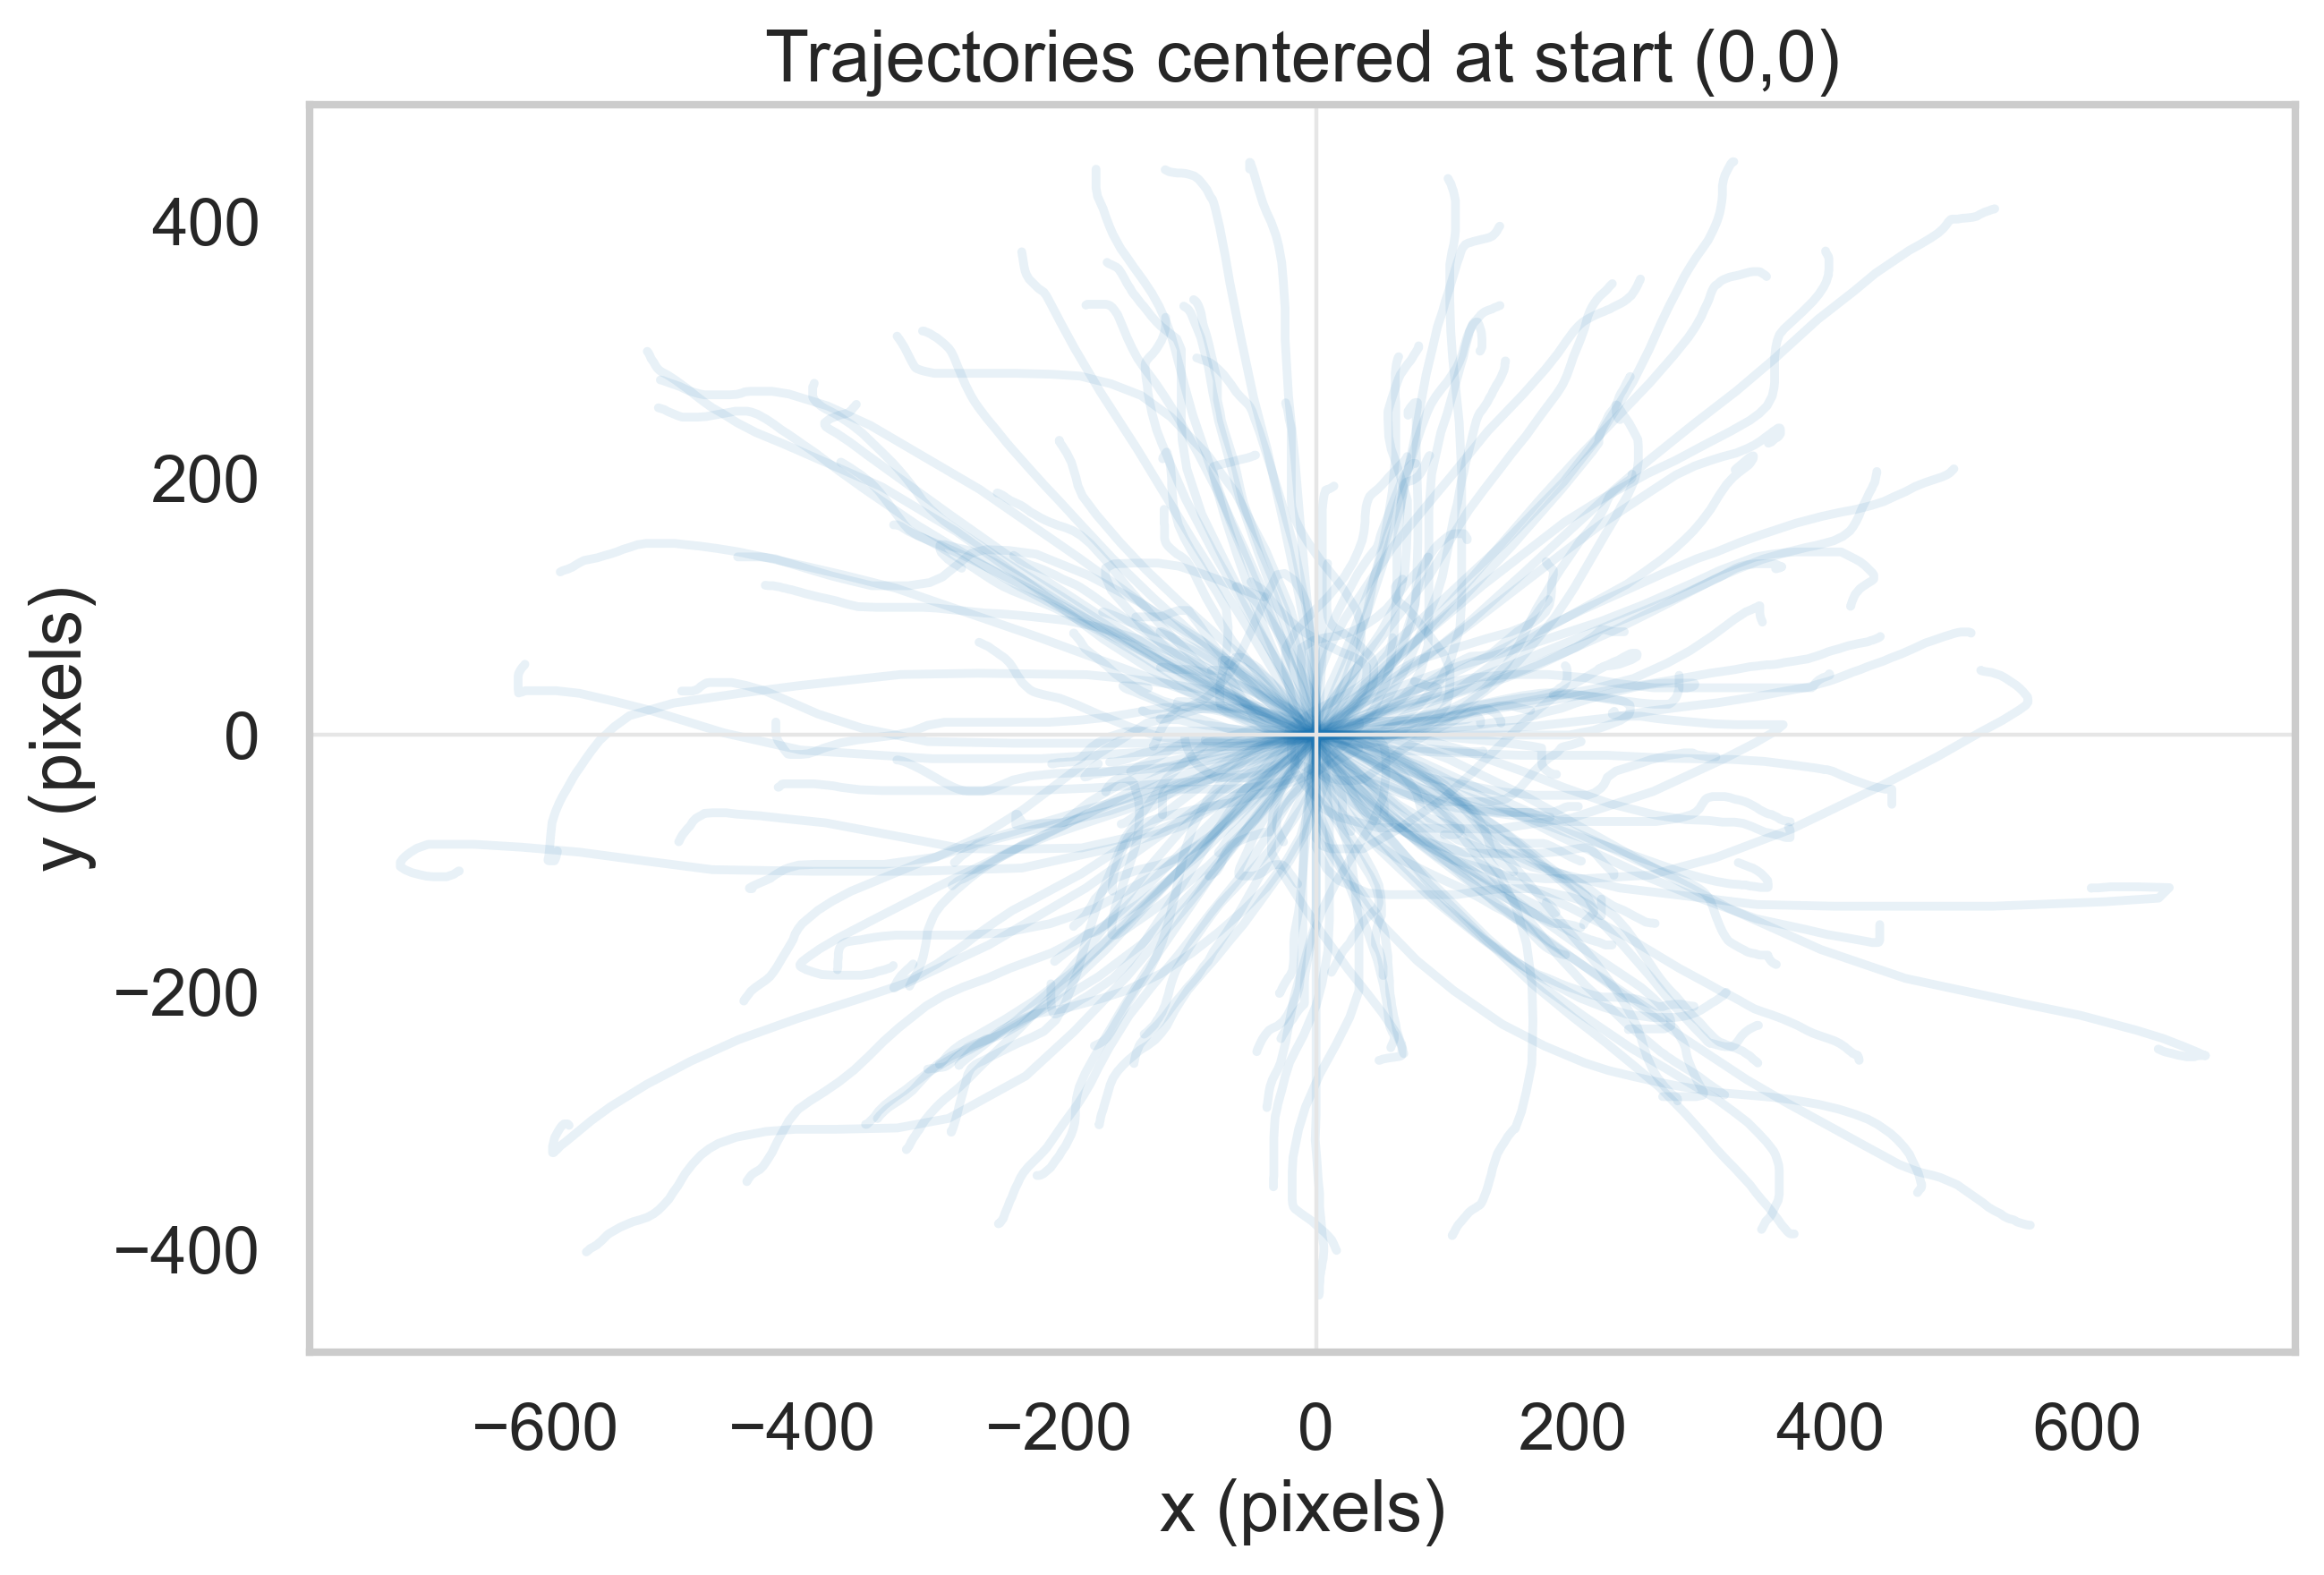

In [ ]:
# Plot all trajectories centered at (0,0) — crisp, no grid
import math
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
# Turn off grid for this plot and use white background
ax.grid(False)
ax.set_facecolor('white')
ax.set_axisbelow(True)
# Adaptive alpha to avoid heavy blur with many trials
n = max(1, len(clean_trials))
alpha = 0.35 if n < 30 else max(0.10, 10.0 / n)
for (t, xc, yc, speed, jerk, tr) in clean_trials:
    ax.plot(xc, yc, color='#1f77b4', alpha=alpha, linewidth=2.2, solid_capstyle='round', solid_joinstyle='round')
# Subtle origin crosshair
ax.axhline(0, color='#e6e6e6', linewidth=1)
ax.axvline(0, color='#e6e6e6', linewidth=1)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Trajectories centered at start (0,0)')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
plt.show()


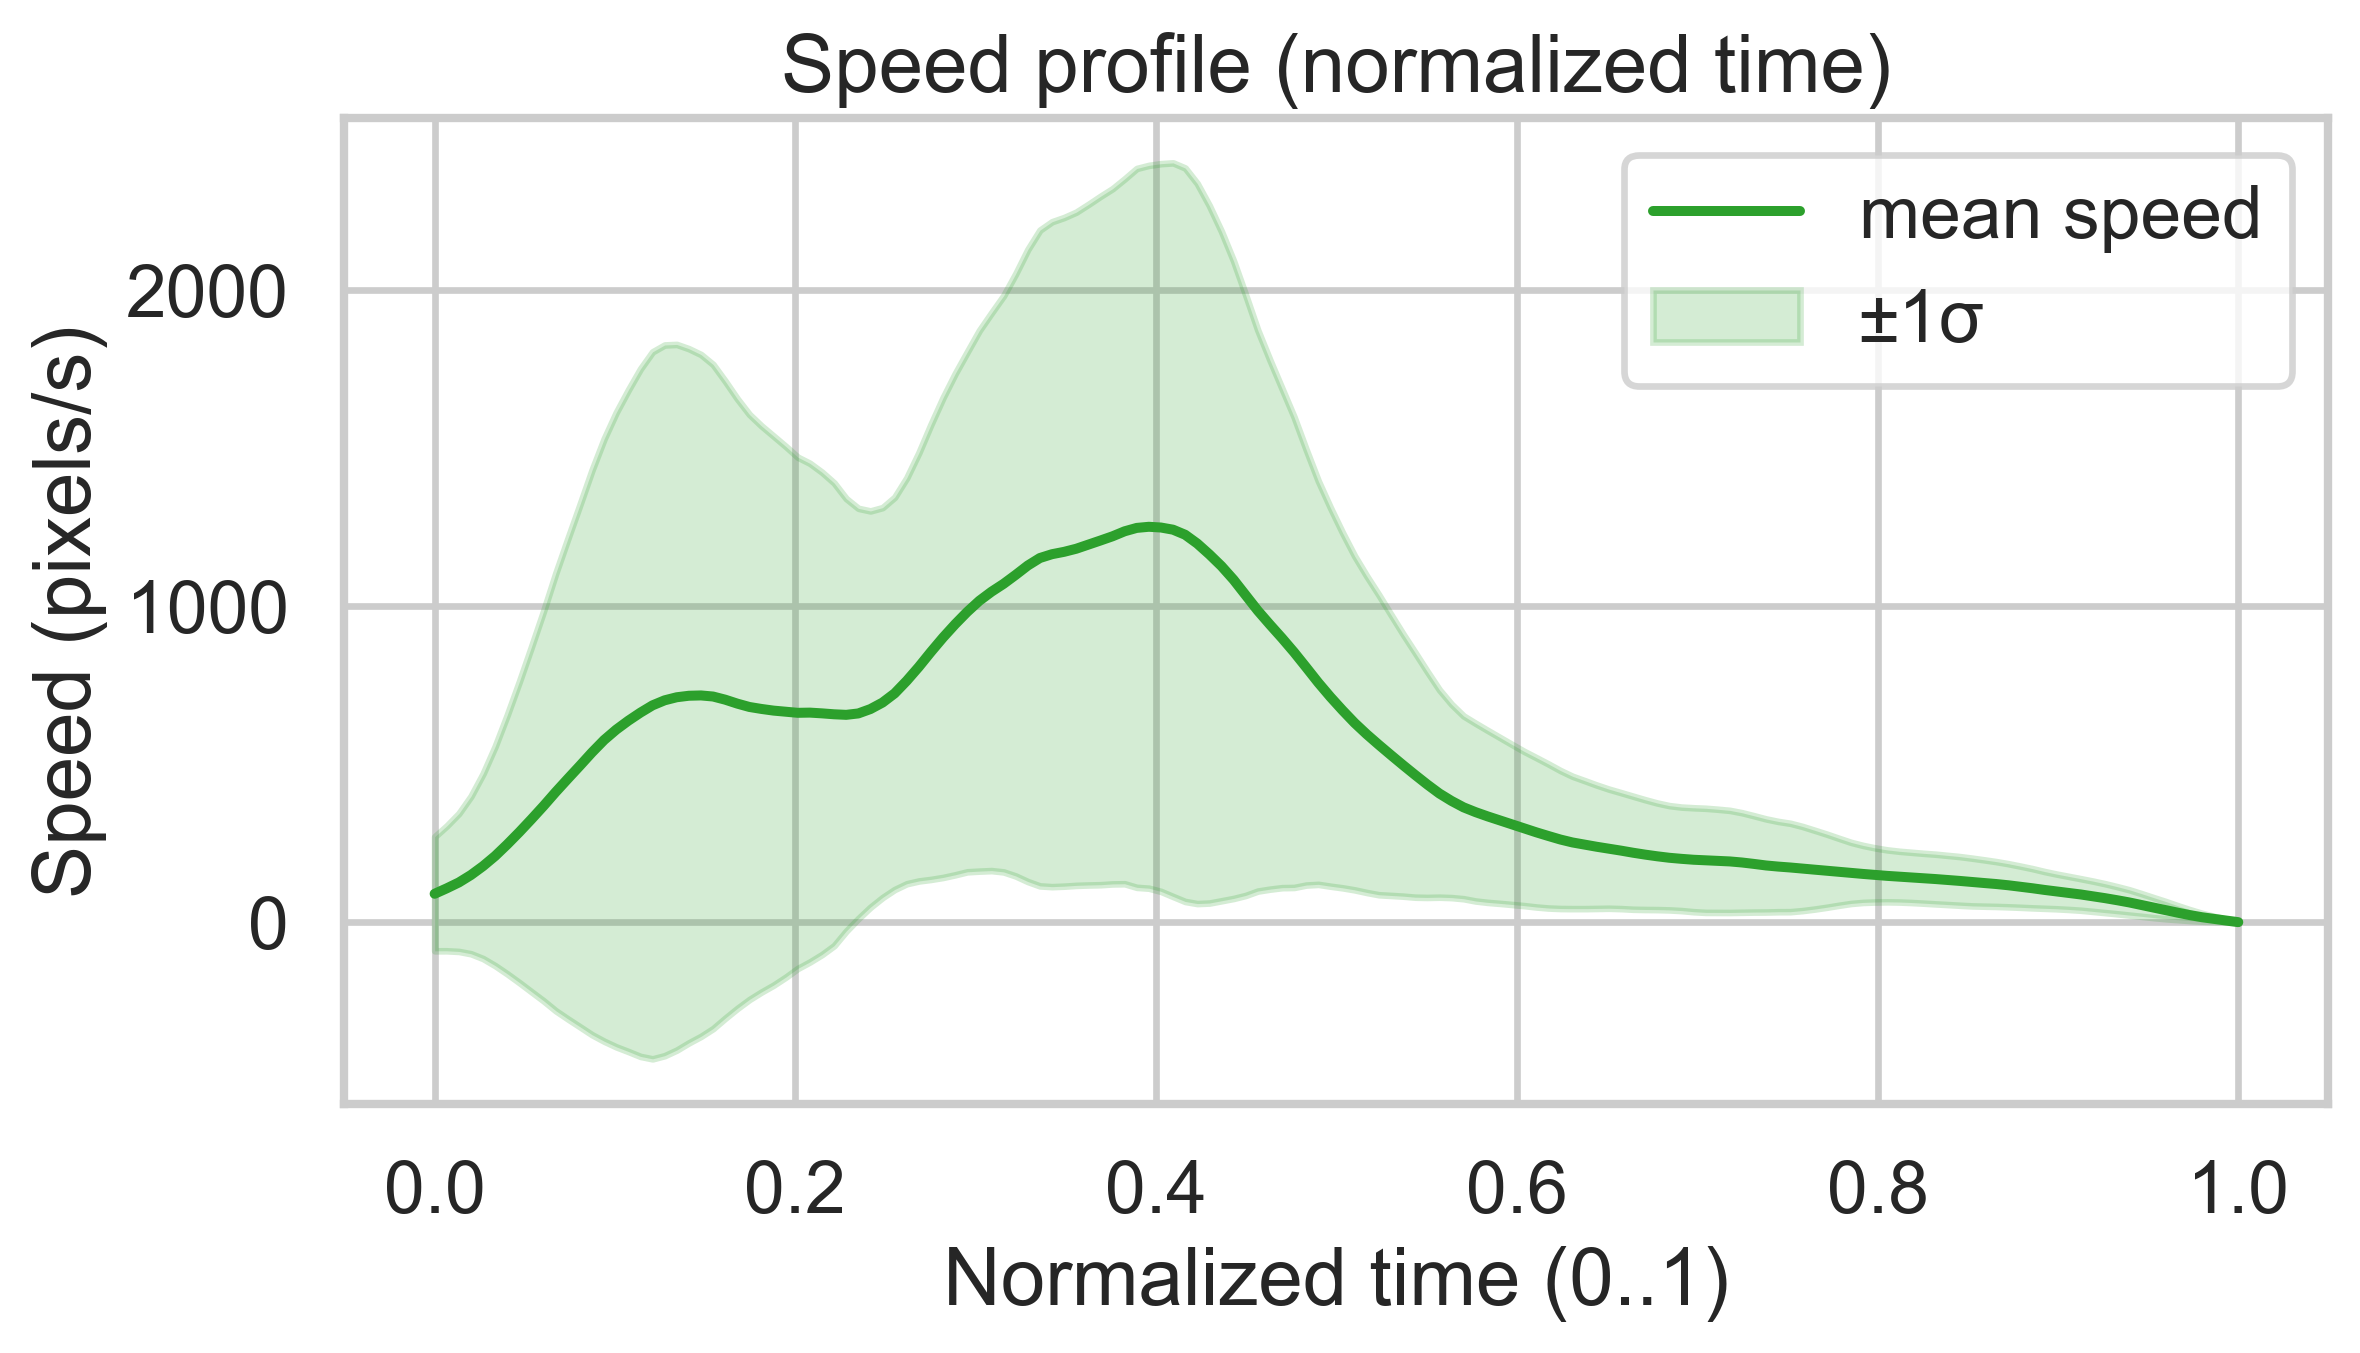

In [ ]:
# Speed profile over normalized time (0..1)
# Build a matrix (trials x 150) and show mean +/- std
if profiles:
    prof_mat = np.vstack(profiles)  # shape: (n_trials, 150)
    u = np.linspace(0, 1, prof_mat.shape[1])
    mean = np.nanmean(prof_mat, axis=0)
    std = np.nanstd(prof_mat, axis=0)
    plt.figure(figsize=(8,4))
    plt.plot(u, mean, color='tab:green', label='mean speed')
    plt.fill_between(u, mean-std, mean+std, color='tab:green', alpha=0.2, label='±1σ')
    plt.xlabel('Normalized time (0..1)')
    plt.ylabel('Speed (pixels/s)')
    plt.title('Speed profile (normalized time)')
    plt.legend()
    plt.show()
else:
    print('No profiles available.')


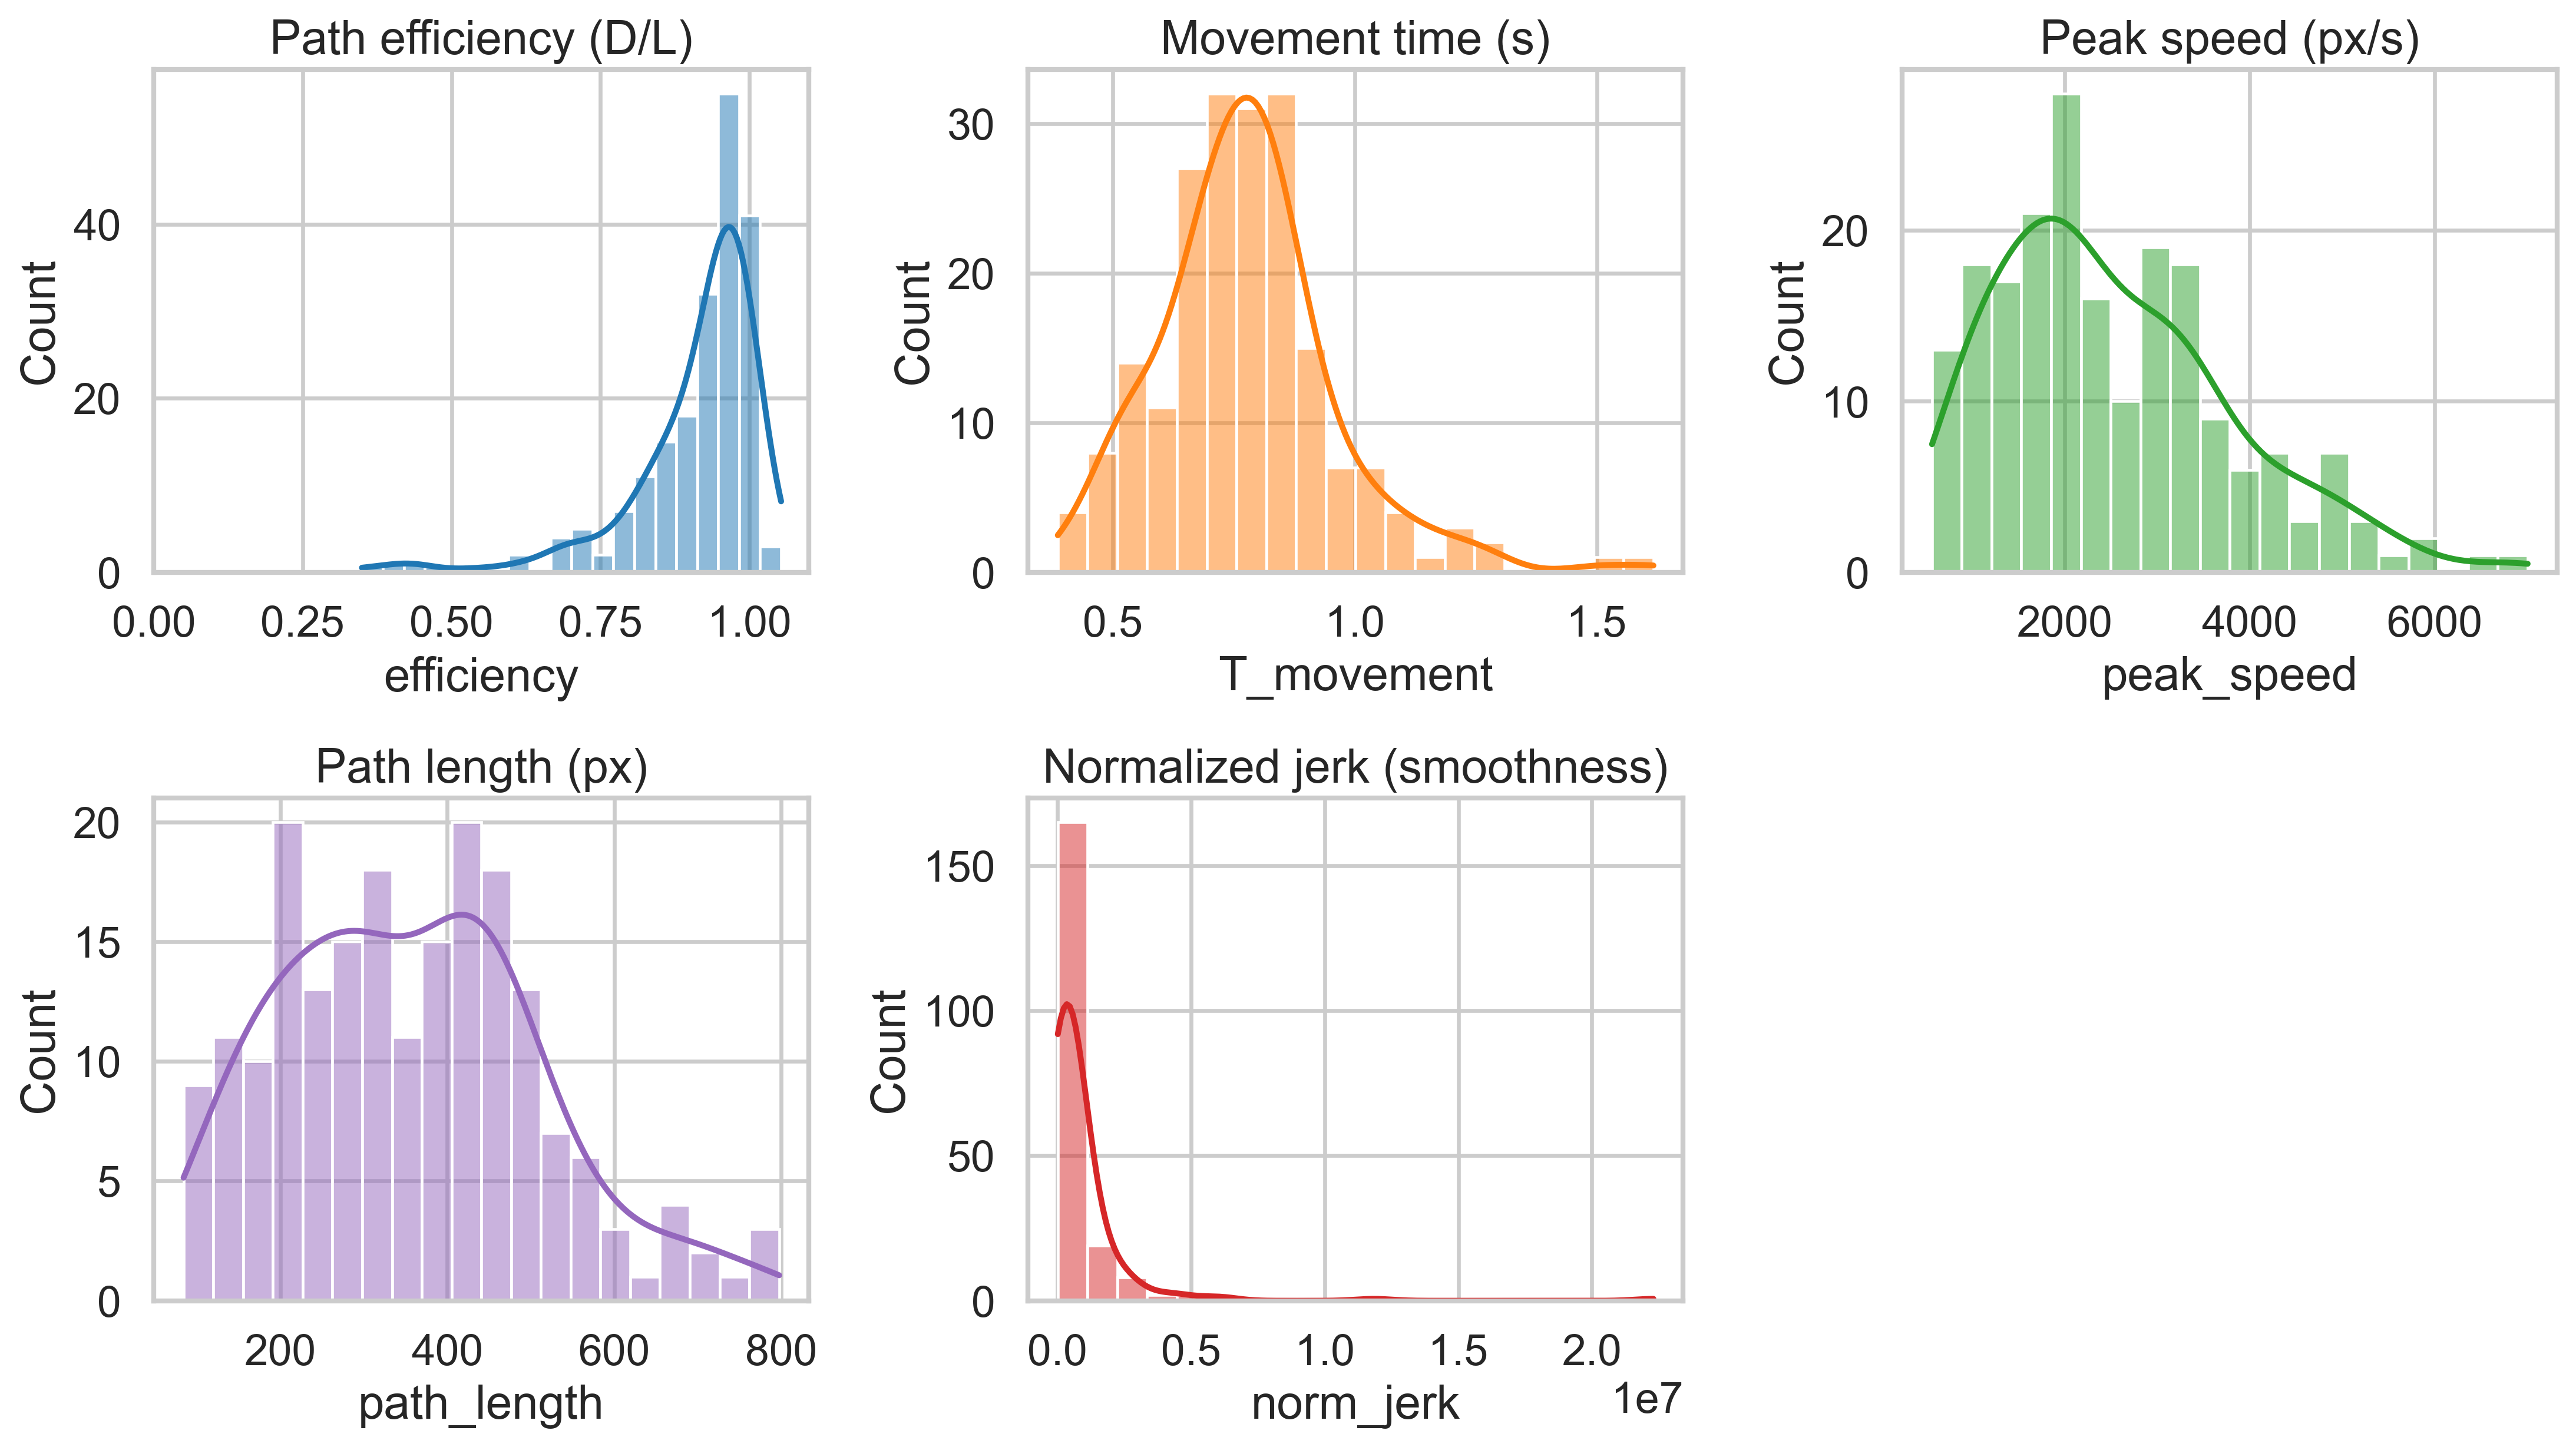

In [ ]:
# Distributions of key metrics
fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.ravel()
sns.histplot(metrics_df['efficiency'], bins=20, kde=True, ax=axes[0], color='tab:blue')
axes[0].set_title('Path efficiency (D/L)')
axes[0].set_xlim(0, 1.1)

sns.histplot(metrics_df['T_movement'], bins=20, kde=True, ax=axes[1], color='tab:orange')
axes[1].set_title('Movement time (s)')

sns.histplot(metrics_df['peak_speed'], bins=20, kde=True, ax=axes[2], color='tab:green')
axes[2].set_title('Peak speed (px/s)')

sns.histplot(metrics_df['path_length'], bins=20, kde=True, ax=axes[3], color='tab:purple')
axes[3].set_title('Path length (px)')

sns.histplot(metrics_df['norm_jerk'], bins=20, kde=True, ax=axes[4], color='tab:red')
axes[4].set_title('Normalized jerk (smoothness)')

axes[5].axis('off')
plt.tight_layout()
plt.show()


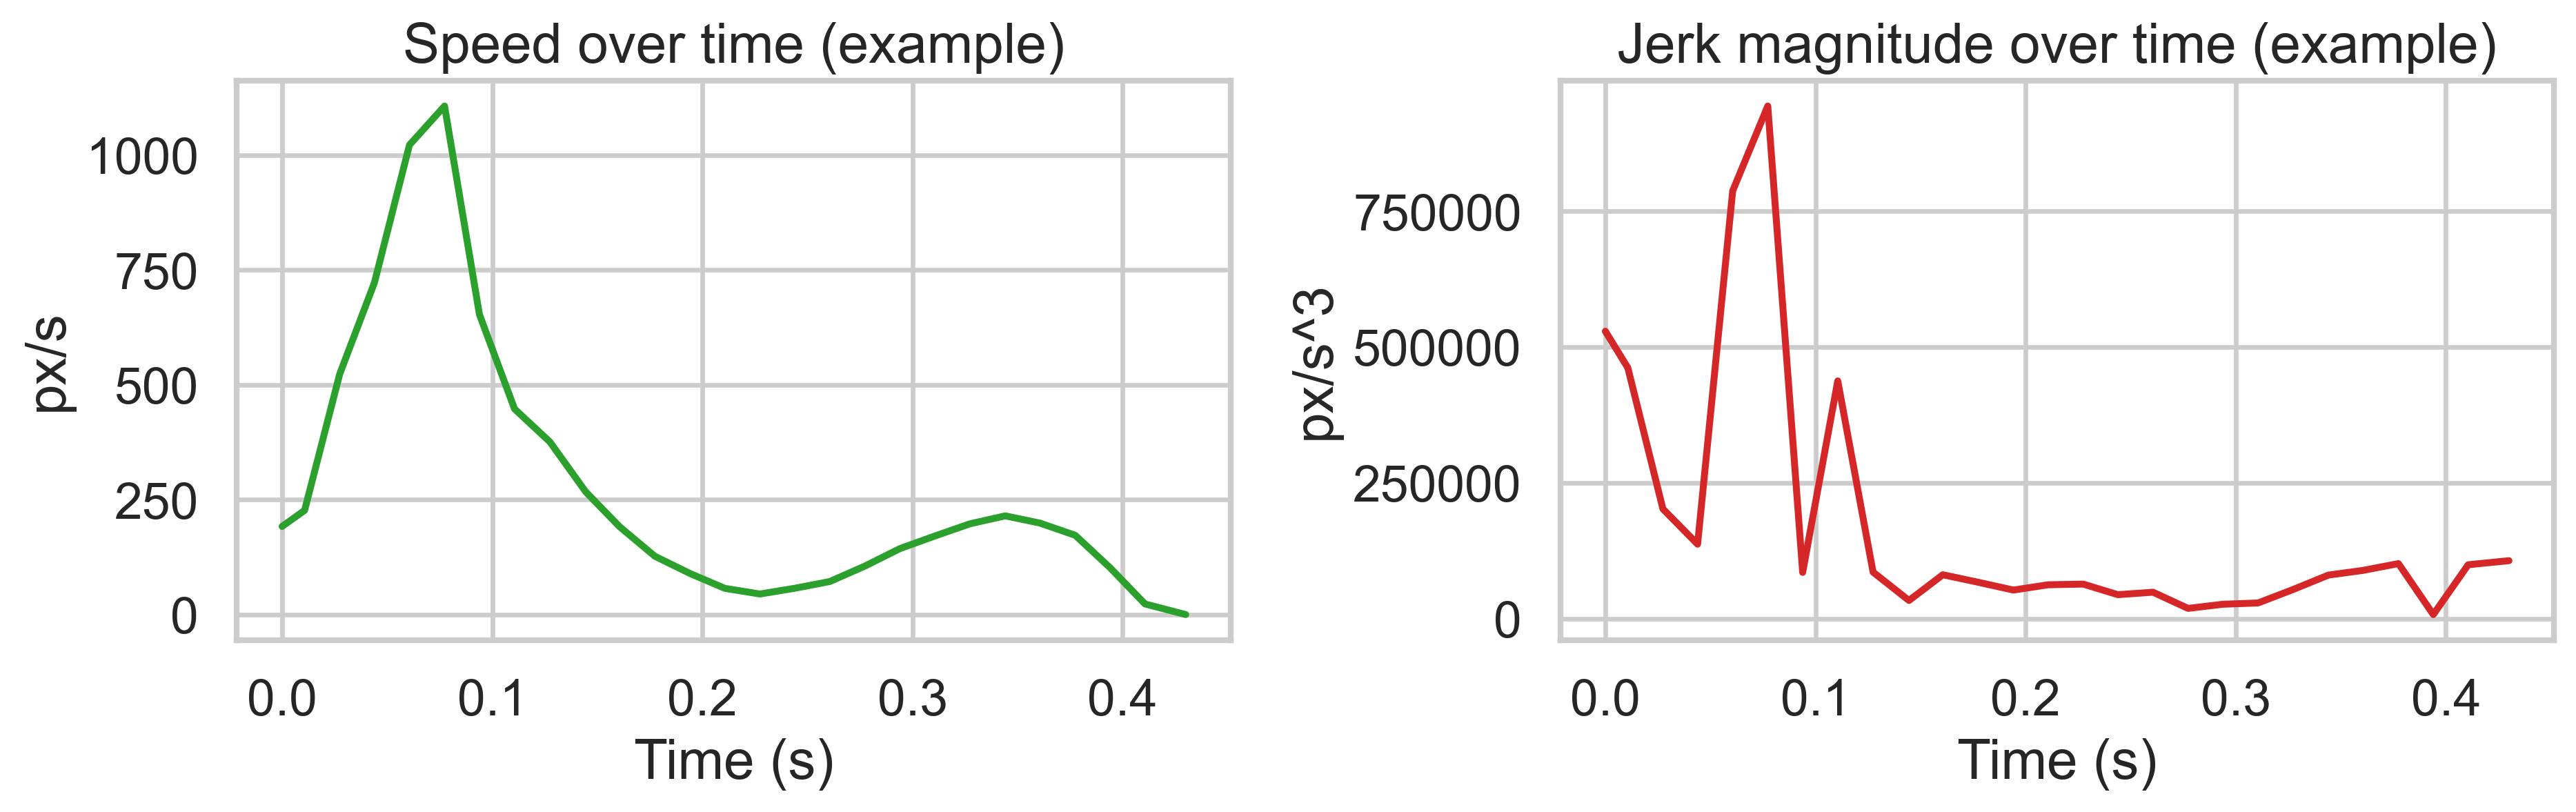

In [ ]:
# Optional: inspect one example trial kinematics (speed and jerk over time)
idx = 0 if clean_trials else None
if idx is not None:
    t, xc, yc, speed, jerk, tr = clean_trials[idx]
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(t - t[0], speed, color='tab:green')
    ax[0].set_title('Speed over time (example)')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('px/s')
    ax[1].plot(t - t[0], jerk, color='tab:red')
    ax[1].set_title('Jerk magnitude over time (example)')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('px/s^3')
    plt.tight_layout()
    plt.show()
else:
    print('No trials available to plot example.')


Notes
- Efficiency uses straight-line distance from the initial cursor position to the target center divided by actual path length.
- Normalized jerk is dimensionless and lower values generally indicate smoother motions.
- Speed profile is averaged on a normalized (0..1) time axis to compare across trials with different durations.
- You can switch `session_file` in the selection cell to analyze a different recording.
